In [1]:
# Imports

from autodisk import *
from autodisk_mtc import *
from mtc_helpers import *

In [2]:
# Input and sanitize 4D-STEM file.

data_name = 'pdpt_x64_y64.raw'
data = readData(data_name)
data = preProcess(data)
img_h,img_w,diff_pat_h,diff_pat_w = data.shape

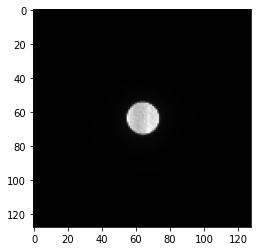

In [6]:
# Determine center disk position and radius from sum pattern

avg_pattern = generateAvgPattern(data)
center_disk,r = ctrRadiusIni(avg_pattern)


In [4]:
# Generate kernel, then cross-correlate

kernel = generateKernel(avg_pattern,center_disk,r,0.7,2)
cros_map = crossCorr(avg_pattern,kernel)

[[6.40000000e+01 6.40000000e+01 2.27993013e+13]
 [6.10000000e+01 4.00000000e+01 2.37060975e+12]
 [8.70000000e+01 6.90000000e+01 2.34123076e+12]
 [3.70000000e+01 3.30000000e+01 1.34558126e+12]
 [1.09000000e+02 5.10000000e+01 1.24563820e+12]
 [5.80000000e+01 1.50000000e+01 1.17213146e+12]
 [4.00000000e+01 5.80000000e+01 1.79459593e+12]
 [8.20000000e+01 2.10000000e+01 9.69791005e+11]
 [9.10000000e+01 9.40000000e+01 1.05744785e+12]
 [1.06000000e+02 2.60000000e+01 9.19227962e+11]
 [6.70000000e+01 8.80000000e+01 1.49075039e+12]
 [1.12000000e+02 7.60000000e+01 9.07659217e+11]
 [3.40000000e+01 9.00000000e+00 6.88807580e+11]
 [8.40000000e+01 4.50000000e+01 1.17387574e+12]
 [1.60000000e+01 5.20000000e+01 5.81417347e+11]
 [1.30000000e+01 2.80000000e+01 4.97376594e+11]
 [4.30000000e+01 8.20000000e+01 8.97824022e+11]
 [1.15000000e+02 1.00000000e+02 4.16098050e+11]
 [1.19000000e+02 3.00000000e+00 3.67051018e+11]
 [1.90000000e+01 7.70000000e+01 4.65869746e+11]
 [1.00000000e+01 3.00000000e+00 4.225409

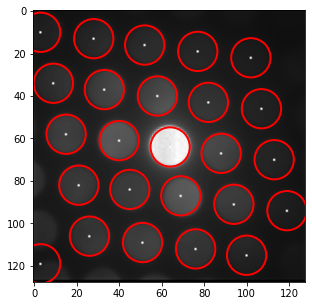

In [7]:
# Detect disks and refine positions with radial gradient maximization

detected_disks = ctrDet(cros_map, r, kernel)
refined_disks_weights = radGradMax(avg_pattern, detected_disks, r,ra=4)
refined_disks_list = refined_disks_weights[:,:2]
print(refined_disks_weights)
drawCircles(np.sqrt(avg_pattern),refined_disks_list,r)

In [ ]:
# Detect the angle of rotation to put disks along a horizontal axis
angle, refined_disks_weights = detAng(refined_disks_weights,center_disk,r)

print('Estimated rotation angle: ',angle,'(deg)')

# Generate the coordinate of disks in the new coordinate system 
rotated_refined_disks_weights = rotCtr(avg_pattern,refined_disks_weights,angle) 

In [ ]:
# Fit the rotated disks to a set of two basis vectors
vec_a_rotated,vec_b_rotated,rotated_refined_disks_weights, middle_row_disks,angle_delta = latFit(avg_pattern,rotated_refined_disks_weights,r)

print('Two lattice vectors: vector_a--[',vec_a_rotated[0],vec_a_rotated[1], '] and vector_b--[',vec_b_rotated[0],vec_b_rotated[1],']')

In [ ]:
generated_lattice_pts = genLat(avg_pattern, vec_a_rotated, vec_b_rotated, middle_row_disks,r)
generated_lattice_pts = delArti(generated_lattice_pts,rotated_refined_disks_weights,r)
rotated_pattern = rotImg(avg_pattern, angle+angle_delta, center_disk)
vec_a, vec_b= latBack(vec_a_rotated, vec_b_rotated, angle)
drawDisks(np.sqrt(rotated_pattern),generated_lattice_pts,r)

In [ ]:
lattice_params = driver_func(data, kernel, r, center_disk, angle)


In [ ]:
lattice_params = np.zeros((img_h,img_w,2,2),dtype = float)
start = time.perf_counter()
percent_complete = 0
time_remaining = 0
avg_time = [0,0]

for row_idx in range (img_h):
    for col_idx in range (img_w):
        result = processPattern(data,row_idx,col_idx,kernel,r,center_disk,angle)
        lattice_params[result[0],result[1],0,:] = result[2]
        lattice_params[result[0],result[1],1,:] = result[3]
        avg_time = timeToFinish(img_h,img_w,avg_time,current_time=time.perf_counter()-start)          
                

    print('Processed {} out of {} rows of patterns.'.format(row_idx+1,img_h))
    
print('-------------------Process Finished-------------------')
avg_time = timeToFinish(img_h,img_w,avg_time,current_time=time.perf_counter()-start)

In [ ]:
lat_fil = latDist(lattice_params,vec_a,vec_b)
st_xx,st_yy,st_xy,st_yx,tha_ang = calcStrain(lat_fil, vec_a, vec_b)

In [ ]:
rdbu = plt.cm.get_cmap('RdBu')
cmap_re = rdbu.reversed()
  
input_min=-0.058
input_max=0.058

l_min = input_min*100
l_max = input_max*100

titles = ["$\epsilon_{xx}(\%)$","$\epsilon_{yy}(\%)$","$\epsilon_{xy}(\%)$","$\Theta$"]
comb = [st_xx,st_yy,st_xy,tha_ang]

fig,axs = plt.subplots(2,2,figsize = (10,10))
i=0
for row in range (2):
    for col in range (2):
        if row==1 and col==1:
            ax = axs[row,col]
            pcm = ax.imshow(comb[i],cmap=cmap_re,vmin=l_min,vmax=l_max)
            ax.set_title(titles[i],fontsize=28)
            ax.set_axis_off()
            fig.colorbar(pcm,ax=ax)
            i +=1
        else:    
            ax = axs[row,col]
            pcm = ax.imshow(comb[i]*100,cmap=cmap_re,vmin=l_min,vmax=l_max)
            ax.set_title(titles[i],fontsize=28)
            ax.set_axis_off()
            fig.colorbar(pcm,ax=ax)
            i +=1
       
plt.subplots_adjust(wspace=0.25,hspace=0.25)
plt.show()